In [3]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geopandas as gpd
from shapely.geometry import Point

from scipy.interpolate import griddata
from skimage.morphology import closing, disk
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries

In [4]:
### Import file 1
#gajhq_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GA  GAJHQ   Jabal al Hasir Data.xlsx"
gajhq_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GA  GAJHQ   Jabal al Hasir Data.xlsx"

gajhq_raw_data = pd.read_excel(gajhq_filepath, sheet_name="Jabal al Hasir Database")
print('File imported successfully')
#gajhq_raw_data.head(5)

File imported successfully


In [5]:
### Set custom headers, drop header rows, and reset index
gajhq_columns_part1 = gajhq_raw_data.iloc[6, 0:3].tolist()
gajhq_columns_part2 = gajhq_raw_data.iloc[4, 3:].tolist()

gajhq_columns = gajhq_columns_part1 + gajhq_columns_part2

print("Number of columns in part1:", len(gajhq_columns_part1))
print('columns1 =', gajhq_columns_part1)
print("Number of columns in part2:", len(gajhq_columns_part2))
print('columns2 =', gajhq_columns_part2)
print("Total columns in data:", gajhq_raw_data.shape[1])

gajhq_data = gajhq_raw_data.copy()
gajhq_data.columns = gajhq_columns
gajhq_data.columns = gajhq_data.columns.str.strip()
gajhq_data = gajhq_data.iloc[7:].reset_index(drop=True)

Number of columns in part1: 3
columns1 = ['Sample No.', 'LONG', 'LAT']
Number of columns in part2: 56
columns2 = ['SiO2', 'Al2O3', 'Fe2O3', 'TiO2', 'CaO', 'MgO', 'Na2O', 'K2O', 'MnO', 'SO3', 'P2O5', 'LOI ', 'Au', 'Ag ', 'As ', 'Ba ', 'Be ', 'Bi ', 'Cd ', 'Ce ', 'Co ', 'Cr ', 'Cu ', 'Dy ', 'Er ', 'Eu', 'Ga', 'Gd', 'Ge ', 'Hf ', 'Ho', 'La ', 'Li ', 'Lu ', 'Mo ', 'Nb ', 'Nd ', 'Ni ', 'Pb ', 'Pr ', 'Sb ', 'Sc ', 'Sm ', 'Sn ', 'Sr ', 'Ta', 'Tb ', 'Th', 'Tm ', 'U ', 'V ', 'W', 'Y ', 'Yb ', 'Zn', 'Zr ']
Total columns in data: 59


In [6]:
def calculate_below_detection_percentage(
    df: pd.DataFrame, dl_row1: pd.Series, dl_row2: pd.Series
) -> dict:
    """
    Calculates the percentage of values below the detection limit (DL) for each column in the DataFrame.

    Parameters:
    - df: Input DataFrame containing numerical data with possible values below DL.
    - dl_row1: First row containing DL components.
    - dl_row2: Second row containing DL components.

    Returns:
    - A dictionary with column names as keys and the percentage below DL as values.
    """
    # Compute the DL values
    detection_limits = pd.to_numeric(dl_row1, errors="coerce").fillna(
        0
    ) + pd.to_numeric(dl_row2, errors="coerce").fillna(0)

    # Initialize a dictionary to store results
    below_dl_percentage = {}

    # Iterate over columns starting from index 3 (assuming first 3 are non-numeric metadata)
    for col_index in range(3, df.shape[1]):
        col_name = df.columns[col_index]
        dl_value = detection_limits[col_index]

        # Count the number of values below the DL
        below_dl_count = (df.iloc[:, col_index] < dl_value).sum()

        # Calculate the percentage below DL
        below_dl_percentage[col_name] = (below_dl_count / len(df)) * 100

    return below_dl_percentage

In [7]:
### Clean data

# Isolate DLs
gajhq_numerical_row = pd.to_numeric(gajhq_raw_data.iloc[5], errors="coerce").fillna(
    0
) + pd.to_numeric(gajhq_raw_data.iloc[6], errors="coerce").fillna(0)

gajhq_DLs = gajhq_numerical_row.to_numpy()
# print("GAJHQ DLs:", gajhq_DLs)

# Replace "<" values with 1/3 of the DL value
for col_index in range(3, gajhq_data.shape[1]):
    dl_value = gajhq_DLs[col_index]

    gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(
        r"<.*", 0.333333 * dl_value, regex=True
    )
    # print(f'replaced <DL values in column {col_index} with {dl_value * 0.333333}')


# Identify columns labeled as '%'
gajhq_labels = gajhq_raw_data.iloc[5].astype(str).fillna("") + gajhq_raw_data.iloc[
    6
].astype(str).fillna("")

gajhq_labels = gajhq_labels.str.strip()

percent_col_indices = gajhq_labels[gajhq_labels.str.contains("%", na=False)].index
percent_numerical_indices = [
    gajhq_raw_data.columns.get_loc(col) for col in percent_col_indices
]

# Convert % to ppm
gajhq_data.iloc[:, percent_numerical_indices] = (
    gajhq_data.iloc[:, percent_numerical_indices] * 10000
)


/var/folders/xc/wpkwk17x20z44scclf26ttt80000gn/T/ipykernel_57713/1090924950.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(


SiO2: 0.00% below DL
Al2O3: 0.00% below DL
Fe2O3: 0.00% below DL
TiO2: 0.00% below DL
CaO: 0.00% below DL
MgO: 0.00% below DL
Na2O: 0.00% below DL
K2O: 0.00% below DL
MnO: 0.00% below DL
SO3: 0.00% below DL
P2O5: 0.00% below DL
LOI: 0.00% below DL
Au: 100.00% below DL
Ag: 100.00% below DL
As: 77.74% below DL
Ba: 0.00% below DL
Be: 30.11% below DL
Bi: 100.00% below DL
Cd: 100.00% below DL
Ce: 1.80% below DL
Co: 0.16% below DL
Cr: 0.00% below DL
Cu: 0.00% below DL
Dy: 0.16% below DL
Er: 1.80% below DL
Eu: 5.56% below DL
Ga: 0.00% below DL
Gd: 4.42% below DL
Ge: 98.69% below DL
Hf: 26.84% below DL
Ho: 10.80% below DL
La: 0.00% below DL
Li: 7.04% below DL
Lu: 97.38% below DL
Mo: 97.71% below DL
Nb: 1.96% below DL
Nd: 0.16% below DL
Ni: 0.00% below DL
Pb: 0.00% below DL
Pr: 1.80% below DL
Sb: 99.18% below DL
Sc: 0.00% below DL
Sm: 0.00% below DL
Sn: 100.00% below DL
Sr: 0.00% below DL
Ta: 65.79% below DL
Tb: 65.47% below DL
Th: 18.66% below DL
Tm: 99.67% below DL
U: 99.84% below DL
V: 0.00%

/var/folders/xc/wpkwk17x20z44scclf26ttt80000gn/T/ipykernel_57713/3178565559.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dl_value = detection_limits[col_index]


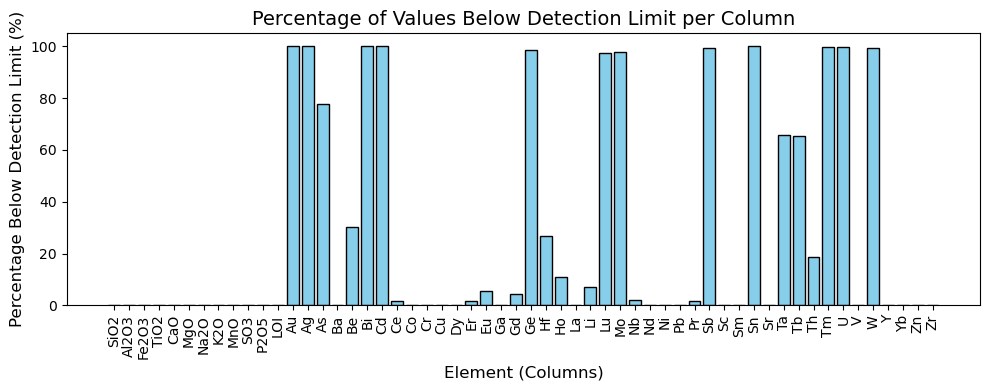

In [9]:
### Calculate + plot below detection limit percentage

# Assuming `gajhq_raw_data` and `gajhq_data` are loaded as in your code
dl_row1 = gajhq_raw_data.iloc[5]
dl_row2 = gajhq_raw_data.iloc[6]
below_dl_results = calculate_below_detection_percentage(gajhq_data, dl_row1, dl_row2)

# Print results
for column, percentage in below_dl_results.items():
    print(f"{column}: {percentage:.2f}% below DL")\
    

# Convert the results to two lists for plotting
columns = list(below_dl_results.keys())
percentages = list(below_dl_results.values())

# Plot the bar chart
plt.figure(figsize=(10, 4))
plt.bar(columns, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Element (Columns)", fontsize=12)
plt.ylabel("Percentage Below Detection Limit (%)", fontsize=12)
plt.title("Percentage of Values Below Detection Limit per Column", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate column names for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()

In [10]:
### Drop columns with n percentage below detection limit

# Calculate percentage below detection limit
below_dl_results = calculate_below_detection_percentage(
    gajhq_data, gajhq_raw_data.iloc[5], gajhq_raw_data.iloc[6]
)

# Drop columns exceeding the threshold percentage below DL

threshold_below_dl = 90

columns_to_drop = [
    col
    for col, percentage in below_dl_results.items()
    if percentage > threshold_below_dl
]
gajhq_data = gajhq_data.drop(columns=columns_to_drop)

# Print the columns that were dropped
print(f"Columns dropped due to exceeding {threshold_below_dl}% below DL:")
print(columns_to_drop)

# Ensure no columns with constant values remain
gajhq_data = gajhq_data.loc[:, gajhq_data.nunique() > 1]

Columns dropped due to exceeding 90% below DL:
['Au', 'Ag', 'Bi', 'Cd', 'Ge', 'Lu', 'Mo', 'Sb', 'Sn', 'Tm', 'U', 'W']


/var/folders/xc/wpkwk17x20z44scclf26ttt80000gn/T/ipykernel_57713/3178565559.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dl_value = detection_limits[col_index]


Statistics:

Average correlation: 0.16078279442025534
Max correlation: 1.0
Min correlation: -0.8096653483925442


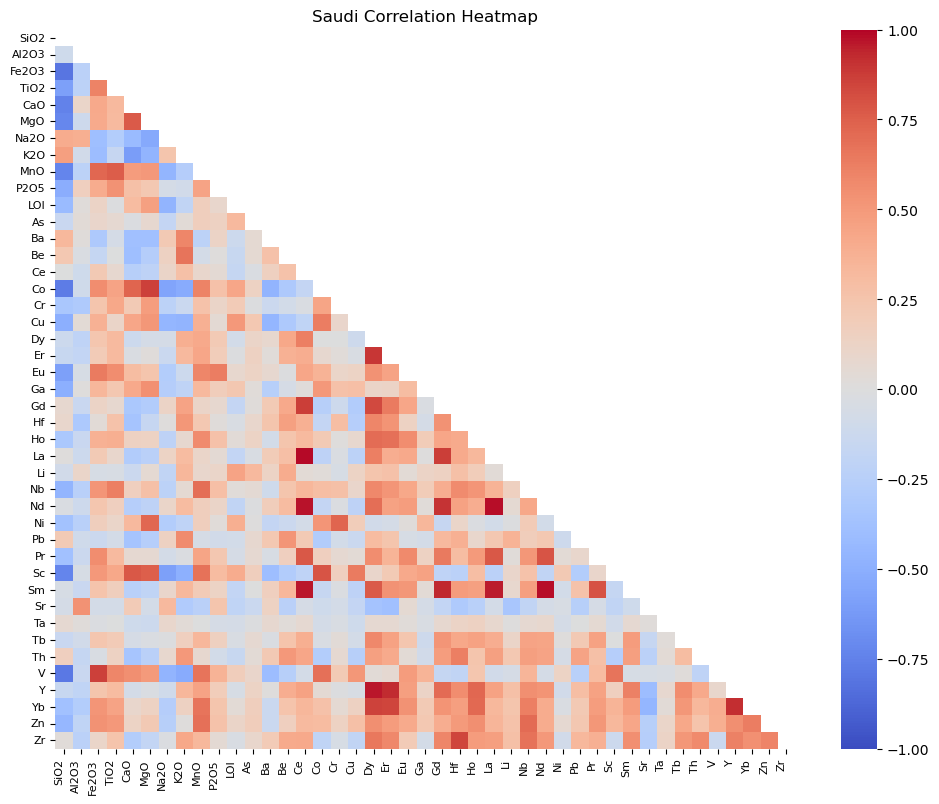

In [11]:
# Corr plot
gajhq_corr = gajhq_data.iloc[:, 3:].corr()

print("Statistics:\n")
print("Average correlation:", gajhq_corr.stack().mean())
print("Max correlation:", gajhq_corr.stack().max())
print("Min correlation:", gajhq_corr.stack().min())

# Create a mask for the upper triangle
gajhq_mask = np.triu(np.ones_like(gajhq_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    gajhq_corr,
    mask=gajhq_mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

# Explicitly set tick positions and labels
tick_positions = np.arange(0.5, len(gajhq_corr))
plt.xticks(
    ticks=tick_positions,
    labels=gajhq_corr.columns,
    rotation=90,
    fontsize=8,
    ha="right",
)
plt.yticks(
    ticks=tick_positions,
    labels=gajhq_corr.index,
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.title("Saudi Correlation Heatmap")
plt.show()

In [12]:
### PCA

# Omit non-numeric columns
gajhq_data_pca = gajhq_data.copy()
gajhq_data_pca = gajhq_data_pca.iloc[:, 3:]

scaler = StandardScaler()
gajhq_data_scaled = scaler.fit_transform(gajhq_data_pca)

# Perform PCA
pca = PCA()
gajhq_pca_results = pca.fit_transform(gajhq_data_scaled)

# Explained variance
gajhq_explained_variance = pca.explained_variance_ratio_
#print("Explained Variance Ratios:", gajhq_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    gajhq_pca_results, columns=[f"PC{i+1}" for i in range(len(gajhq_explained_variance))]
)

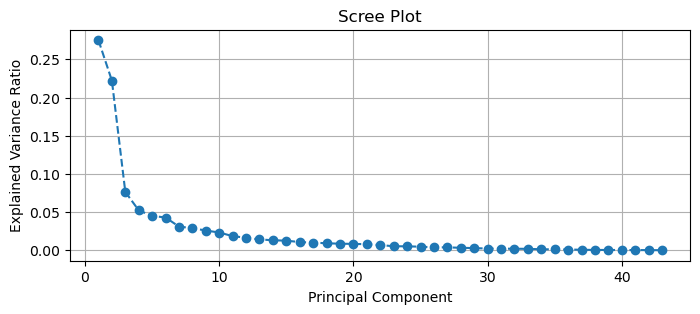

In [13]:
#Plot PCA scree plot
plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(gajhq_explained_variance) + 1),
    gajhq_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

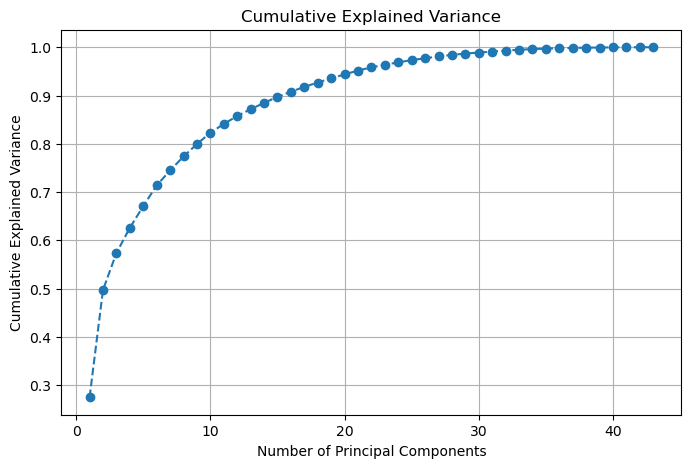

In [14]:
cumulative_variance = gajhq_explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

PC1: ['Dy', 'Y', 'Yb', 'Sm', 'Er']
PC2: ['Co', 'Sc', 'MgO', 'CaO', 'SiO2']
PC3: ['Sr', 'Li', 'Ce', 'Pr', 'La']
PC4: ['Ni', 'Cr', 'Al2O3', 'P2O5', 'MgO']
PC5: ['TiO2', 'LOI', 'Li', 'Cu', 'Ce']


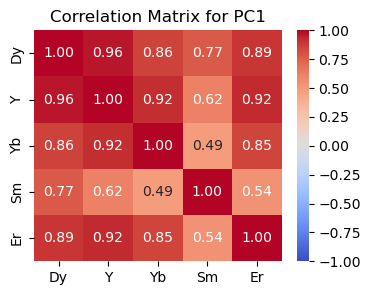

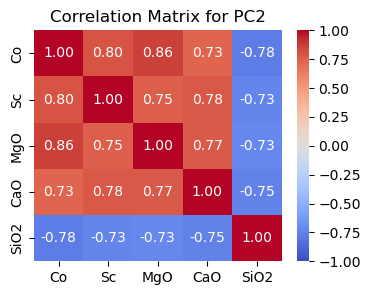

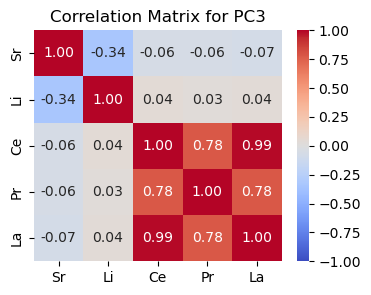

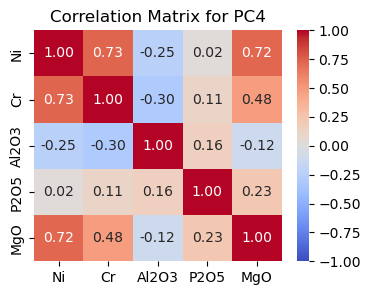

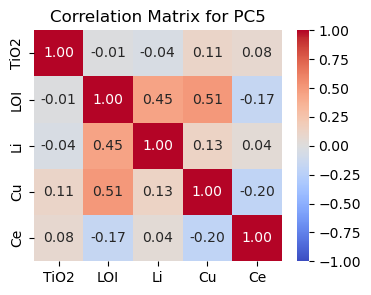

In [15]:
### Extract top features per PC

# Set parameters
num_pcs = 5  # Number of PCs to analyze
top_features_per_pc = 5  # Number of top features to extract per PC

# Prepare lists for groups of features
groups = {}

# Iterate through each PC and extract top features
for pc_index in range(num_pcs):
    # Extract feature contributions for the current PC
    contributions = pd.DataFrame(
        {
            "Feature": gajhq_data_pca.columns,
            f"PC{pc_index + 1} Contribution": np.abs(pca.components_[pc_index]),
        }
    )
    # Sort by contribution and select top features
    top_features = contributions.nlargest(
        top_features_per_pc, f"PC{pc_index + 1} Contribution"
    )["Feature"].tolist()
    groups[f"PC{pc_index + 1}"] = top_features

# Display groups of correlated features
for pc, features in groups.items():
    print(f"{pc}: {features}")

# Plot correlation matrices for each PC group
for pc, features in groups.items():
    plt.figure(figsize=(4, 3))
    corr_matrix = gajhq_data_pca[features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for {pc}")
    plt.show()

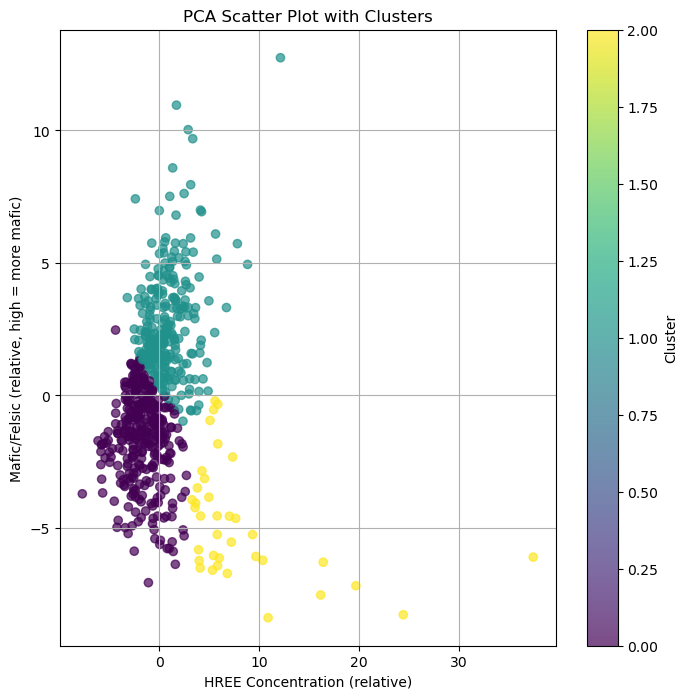

In [16]:
# Perform clustering on the PCA results (e.g., using the first 2 PCs)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df[["PC1", "PC2"]])

# Add cluster labels to the PCA DataFrame
pca_df["Cluster"] = clusters

# Visualize clusters on the PCA scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"], cmap="viridis", alpha=0.7
)
plt.title("PCA Scatter Plot with Clusters")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

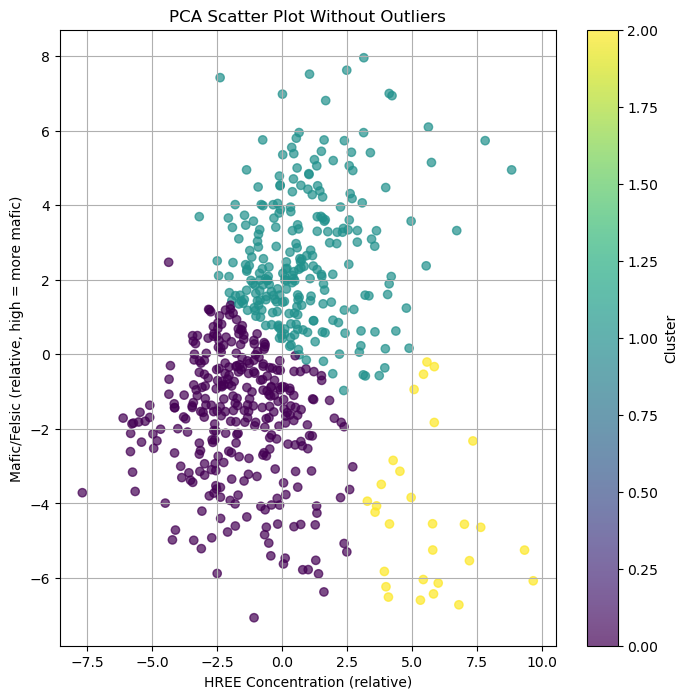

In [17]:
# Define thresholds for PC1 (HREE concentration) and PC2 (mafic/felsic)
pc1_threshold = 10  # Keep samples with PC1 < 10
pc2_threshold = 8  # Keep samples with PC2 < 8

# Filter out outliers
filtered_data = pca_df[
    (pca_df["PC1"] < pc1_threshold) & (pca_df["PC2"] < pc2_threshold)
]

# Replot without outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    filtered_data["PC1"],
    filtered_data["PC2"],
    c=filtered_data["Cluster"],
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(label="Cluster")
plt.title("PCA Scatter Plot Without Outliers")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.grid()
plt.show()

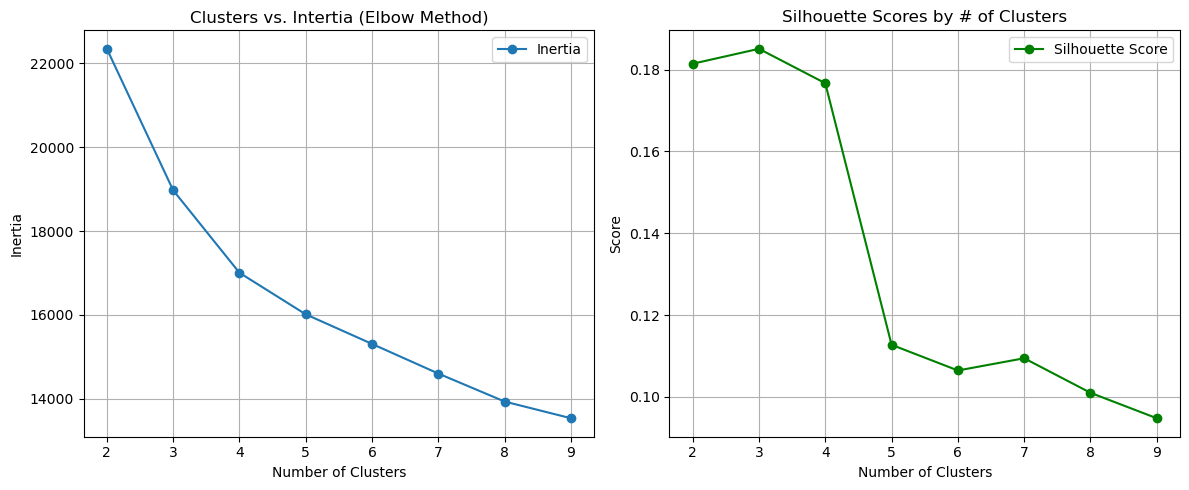

In [19]:
# Step 1: Preprocessing - Select numeric geochemical data and standardize
gajhq_data_numeric = gajhq_data.iloc[:, 3:].copy()  # Exclude non-numeric columns
gajhq_data_numeric = gajhq_data_numeric.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric
scaler = StandardScaler()
gajhq_data_scaled2 = scaler.fit_transform(gajhq_data_numeric)

# Step 2: Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette = []

for k in range(2, 10):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gajhq_data_scaled2)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(gajhq_data_scaled2, kmeans.labels_))

# Plot Inertia (Elbow) and Silhouette Scores
plt.figure(figsize=(12, 5))

# Inertia (Elbow)
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker="o", label="Inertia")
plt.title("Clusters vs. Intertia (Elbow Method)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette, marker="o", label="Silhouette Score", color="green")
plt.title("Silhouette Scores by # of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Step 3: Perform K-means clustering with optimal number of clusters (e.g., k=3)
gajhq_optimal_k = 3  # Based on the elbow plot
gajhq_kmeans = KMeans(n_clusters=gajhq_optimal_k, random_state=42)
gajhq_clusters = gajhq_kmeans.fit_predict(gajhq_data_scaled2)

# Step 4: Convert scaled data back to a DataFrame
gajhq_data_scaled_df = pd.DataFrame(
    gajhq_data_scaled2, columns=gajhq_data_numeric.columns
)  # Use original column names
gajhq_data_scaled_df["Cluster"] = gajhq_clusters  # Add cluster assignments

# Step 5: Analyze clustering results
print('Clustering Complete\n.............\n')
print(
    gajhq_data_scaled_df.groupby("Cluster").mean()
)  # Compare mean geochemical values for each cluster

Clustering Complete
.............

             SiO2     Al2O3     Fe2O3      TiO2       CaO       MgO      Na2O  \
Cluster                                                                         
0        0.635826  0.084096 -0.547981 -0.377035 -0.468045 -0.518321  0.417597   
1       -0.830579 -0.022128  0.646364  0.441713  0.716625  0.739065 -0.550555   
2        0.544685 -0.672216  0.119881  0.108050 -1.293610 -0.969875  0.400572   

              K2O       MnO      P2O5  ...        Sm        Sr        Ta  \
Cluster                                ...                                 
0        0.256426 -0.606546 -0.309360  ... -0.182200  0.227021  0.023468   
1       -0.512573  0.681734  0.433997  ... -0.113028 -0.159971 -0.054810   
2        1.726438  0.418679 -0.518511  ...  2.822057 -0.964301  0.225018   

               Tb        Th         V         Y        Yb        Zn        Zr  
Cluster                                                                        
0       -0.205470 

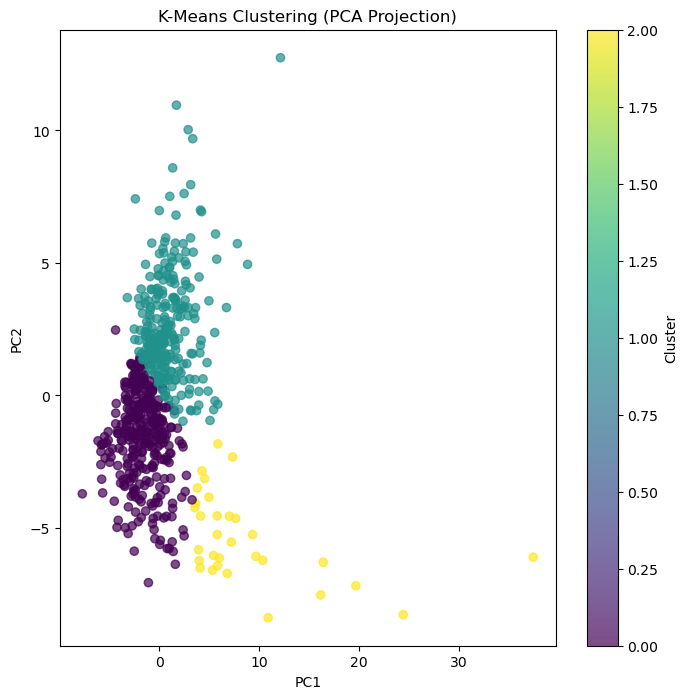

In [21]:
# Reduce dimensions with PCA for visualization
pca2 = PCA(n_components=3)
gajhq_data_pca2 = pca2.fit_transform(gajhq_data_scaled2)

# Plot clusters
PC1 = 0
PC2 = 1

plt.figure(figsize=(8, 8))
plt.scatter(gajhq_data_pca2[:, PC1], gajhq_data_pca2[:, PC2], c=gajhq_clusters, cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel(f"PC{PC1+1}")
plt.ylabel(f"PC{PC2+1}")
plt.colorbar(label="Cluster")
plt.show()

In [22]:
### Spatial Investigation

gajhq_data_spatial = gajhq_data.iloc[:, 1:].copy()  
gajhq_data_spatial = gajhq_data_spatial.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric

# Convert the DataFrame to a GeoDataFrame
gajhq_data_spatial["geometry"] = gajhq_data_spatial.apply(
    lambda row: Point(row["LONG"], row["LAT"]), axis=1
)
gajhq_geo_data = gpd.GeoDataFrame(
    gajhq_data_spatial, geometry="geometry", crs="EPSG:4326"
)  # WGS84 CRS
gajhq_geo_data["Cluster"] = gajhq_clusters

# Inspect the GeoDataFrame
#print(gajhq_geo_data.head())
#print(gajhq_geo_data["Cluster"].unique())

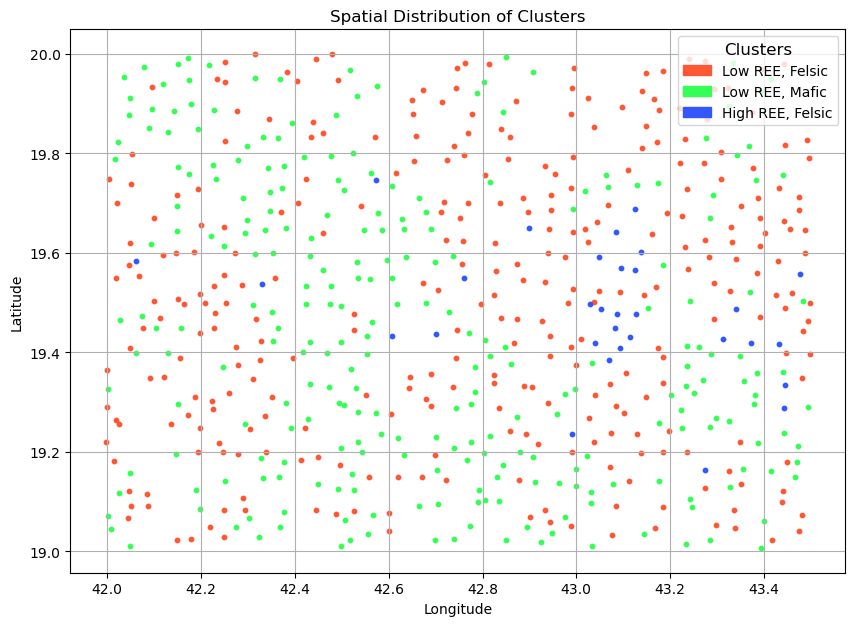

In [23]:
### Spatial Analysis

# Custom cluster colors (ensure consistency with the plot)
cluster_colors = {
    0: "#FF5733",
    1: "#33FF57",
    2: "#3357FF",
}  # Vibrant colors for clusters

# Add a 'Color' column to GeoDataFrame
gajhq_geo_data["Color"] = gajhq_geo_data["Cluster"].map(cluster_colors)

# Define new names for the clusters
cluster_names = {0: "Low REE, Felsic", 1: "Low REE, Mafic", 2: "High REE, Felsic"}

# Add a new column to the GeoDataFrame with descriptive cluster names
gajhq_geo_data["Cluster_Name"] = gajhq_geo_data["Cluster"].map(cluster_names)

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))
for cluster, color in cluster_colors.items():
    subset = gajhq_geo_data[gajhq_geo_data["Cluster"] == cluster]
    subset.plot(color=color, markersize=10, ax=ax, label=f"Cluster {cluster}")

# Add a categorical legend (aligned with cluster colors)
handles = [
    mpatches.Patch(color=color, label=cluster_names[cluster])
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=handles, title="Clusters", loc="upper right", fontsize=10, title_fontsize=12
)

# Add titles and labels
plt.title("Spatial Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

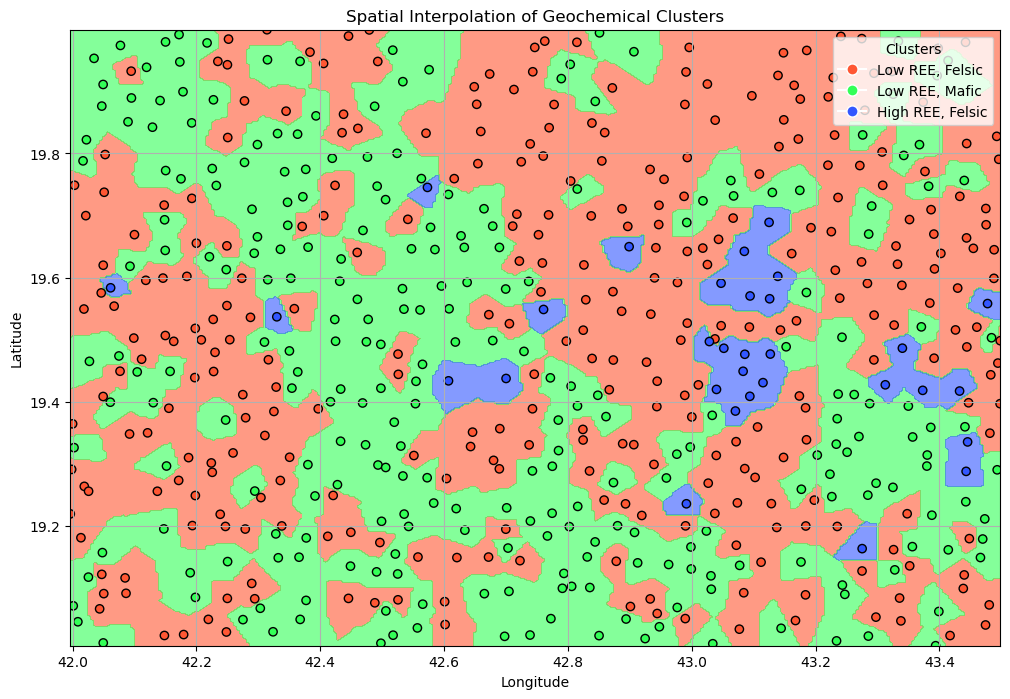

In [24]:
# Extract spatial coordinates and cluster labels
x = gajhq_geo_data["LONG"].values
y = gajhq_geo_data["LAT"].values
z = gajhq_geo_data["Cluster"].values  # Cluster labels

# Define the grid for interpolation
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),  # Adjust resolution
    np.linspace(y.min(), y.max(), 300),
)

# Perform nearest neighbor interpolation
zi = griddata((x, y), z, (xi, yi), method="nearest")

# Use your custom colors for the clusters
custom_cmap = ListedColormap([cluster_colors[i] for i in sorted(cluster_colors.keys())])

# Plot the interpolated clusters
plt.figure(figsize=(12, 8))
plt.contourf(
    xi,
    yi,
    zi,
    levels=np.arange(len(cluster_colors) + 1) - 0.5,
    cmap=custom_cmap,
    alpha=0.6,
)
#plt.colorbar(ticks=range(len(cluster_colors)), label="Cluster")  # Add a colorbar
plt.scatter(
    x, y, c=z, cmap=custom_cmap, edgecolor="k", label="Sample Points"
)  # Overlay sample points
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Interpolation of Geochemical Clusters")
plt.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=cluster_names[cluster],
            markersize=8,
            markerfacecolor=color,
        )
        for cluster, color in cluster_colors.items()
    ],
    title="Clusters",
    loc="upper right",
)
plt.grid()
plt.show()